In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from corner import corner
from scipy.special import binom
import emcee

from multiprocessing import Pool

# The problem

We want to know how well people classify AGN with mergers.

We have 8 classifiers and 144 classifiers, with 41 fake.

We want to know how many real mergers $M$ and isolated $N-M$.

We also have 70 control galaxies.

Base is $B=70$, control $C=74$, fake mergers $F_m=24$, and fake isolated galaxies$F_I=17$, and we have $N=8$ people classifying.

We want the number real mergers in $B$, $B_m$.


$B_j$ is the number of the mergers that classifier $j$ says.

$r_j$ is the true positive merger, $\hat F_{m,j}/F_{m,j}$, and a true positive isolated, $r'_j$, that is $\hat F_{I,j}/F_{I,j}$. Basically how many things they correctly called mergers that were mergers, and how many things they correctly identified as isolated mergers.


The likelihood should be
$$
L=\prod_j^N\sum_k f_b(k, B_m, r_j)f_b(B_j-k,B-B_m,1-r_j')
$$
He defined $f_b(k, B_m, r_j)$, which is the real merger rate, sort of a binomial distribution.

Also, we have $f_b(B_j-k, B-B_m, 1-r_j')$ as the isolated identified as a merger binomial.

$k$ is the number of observed, $B_m$ is the total sample, and $r_j$ is the probability.


So we are assuming $B_m$ total true mergers in the sample. We want to estimate that. By definition, there are $B-B_m$ true isolated variables in the sample.

Let's say then the person correctly classified $k$ mergers, and they mis-classified $B_j-k$.

OK, I think this basically makes sense. In this notation, 
$$
f_b(k, n, p) = \binom{n}{k}p^k(1-p)^k
$$

If we want to take into account the prior, we would want to have this prior distribution $f(\hat F_{m,j},F_{m,j},r_j)$ and $f(\hat F_{I,j}, F_{I,j}, r'_j)$. This makes the likelihood;
$$
L=\prod_j^N f(\hat F_{m,j},F_{m,j},r_j)f(\hat F_{I,j}, F_{I,j}, r'_j)\sum_k f_b(k, B_m, r_j)f_b(B_j-k,B-B_m,1-r_j')
$$


Let's look at a simple eample; for $B=70$ galaxies, and $B_j = 50$, they have a correct merger identification rate $r_j=16/24$, and a correct correct isolated merger rate $r_j'=11/70$.

In [2]:
def f_b(k, n, p):
    return binom(n,k)*p**k*(1-p)**(n-k)

In [3]:
def L(Bm, rj, rjp, Bj, B):
    L = 0
    Bm = Bm.astype(int)
    for k in range(Bj+1):
        L += f_b(k, Bm, rj)*f_b(Bj-k, B-Bm, 1-rjp)
    return L

Text(0.5, 0, 'Estimated true underlying mergers $B_m$')

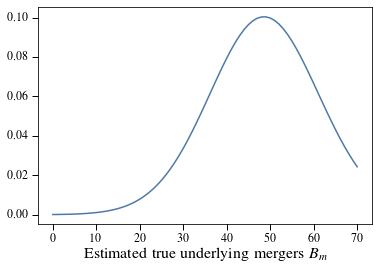

In [4]:
rj = 16/24
rjp = 11/17
Bj = 40
B = 70

Bm = np.arange(B+1)
plt.plot(Bm, L(Bm, rj, rjp, Bj, B))
plt.xlabel(r'Estimated true underlying mergers $B_m$')

35.375 7.192661190407901


Text(0.5, 0, 'Estimated true underlying mergers $B_m$')

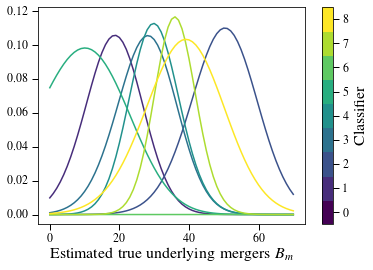

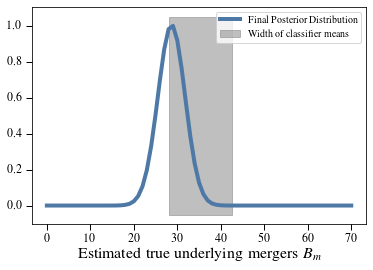

In [5]:
rjs = np.array([11, 16, 19, 20, 18, 17,18,20])/24
rjps = np.array([11, 14, 13, 12, 13, 8, 9, 13])/17
Bjs = np.array([50, 41, 45, 35, 39, 43, 44, 48])

rjs = np.array([0.75      , 0.79166667, 0.79166667, 0.66666667, 0.83333333, 0.79166667, 0.75, 0.75])
rjps = np.array([0.70588235, 0.58823529, 0.64705882, 0.82352941, 0.47058824,
       0.35294118, 0.82352941, 0.59])
Bjs = np.array([29, 48, 37, 27, 40, 27, 33, 42])

print(Bjs.mean(), Bjs.std())
#cm = plt.cm.viridis
cm = plt.cm.get_cmap('viridis', len(rjs)+1)

for i in range(len(rjs)):
    plt.plot(Bm, L(Bm, rjs[i], rjps[i], Bjs[i], B), color=cm((i+1)/(len(rjs)+1)))
plt.xlabel(r'Estimated true underlying mergers $B_m$')

sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=0-0.5, vmax=len(rjs)+0.5))
plt.colorbar(sm, label='Classifier')

    
plt.figure()
lnLi = L(Bm, rjs[i], rjps[i], Bjs[i], B)*0

for i in range(len(rjs)):
    lnLi += np.log(L(Bm, rjs[i], rjps[i], Bjs[i], B))
plt.plot(Bm, np.exp(lnLi-lnLi.max()),  label='Final Posterior Distribution', lw=4)
plt.fill_betweenx(plt.gca().get_ylim(), Bjs.mean()-Bjs.std(), Bjs.mean()+Bjs.std(), alpha=0.5, 
                  color='gray', label=r'Width of classifier means')
plt.legend(loc='best')
plt.xlabel(r'Estimated true underlying mergers $B_m$')

In [6]:
Like = np.exp(lnLi-lnLi.max())
mu = sum(Bm*Like)/sum(Like)
var = sum(Bm**2*Like)/sum(Like) - mu**2
print(mu, var**0.5)

28.64698902460246 3.137843712863772


We want to make sure $r_j$ and $B_j$ need to be consistent. Each prior's $f_b(\hat F_{m,j}, F_{m,j}, r_j)$ and $f(\hat F_{I,j},F_{I,j},r_j')$ needs to be taken into account.

In the notation from before, this is equivalent to 

In [7]:
F_m = 24
F_I = 17

#F_mhats = np.array([11, 16, 19, 20, 18, 17,18,20])
#F_Ihats = np.array([11, 14, 13, 12, 13, 8, 9, 13])
F_mhats = rjs*F_m
F_Ihats = rjps*F_I

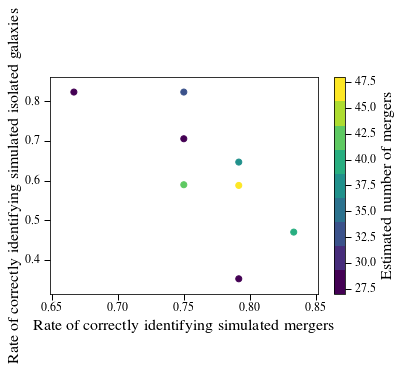

In [8]:
plt.scatter(rjs, rjps, c=Bjs, cmap=cm)
plt.xlabel(r'Rate of correctly identifying simulated mergers')
plt.ylabel(r'Rate of correctly identifying simulated isolated galaxies')
plt.colorbar(label='Estimated number of mergers')

This can be described by a beta distribution, which is just the conjugate prior to the binomial distribution. To do it correctly, we need to normalize, but I'm lazy.

In [9]:
def f_b(k, n, p):
    if p == 0:
        return 0
    elif p == 1:
        return 0
    else:
        return binom(n,k)*p**k*(1-p)**(n-k)
# The arguments are Bm, number of true underlying mergers, rj, the fraction of correctly identified mergers, rjp, the number
# of correctly identified isolated galaxies, Bj, the number of galaxies that the classifier calls mergers, B, the total
# number of galaxies in the sample, F_m, the number of fake mergers, F_I, the number of fake isolated galaxies,
# F_mhat, the number that the classifier correctly identifies as mergers, and F_Ihat, the number
# that the classifier correctly identifies as isolted galaxies.
def L(Bm, rj, rjp, Bj, B, F_m, F_I, F_mhat, F_Ihat):
    '''
    This is the likelihood for an individual classifier
    '''
    L = 0
    for k in range(min(Bj+1,int(Bm))):
        L += f_b(k, Bm, rj)*f_b(Bj-k, B-Bm, 1-rjp)
    return L*f_b(F_mhat, F_m, rj)*f_b(F_Ihat, F_I, rjp)

def lnlike(args, Bjs, B, F_m, F_I, F_mhat, F_Ihat):
    '''
    This returns the product of all of the individual classifiers' results.
    '''
    Bm, rs = args[0], args[1:]
    Bm = int(Bm)
    rjs, rjps = np.split(rs, 2)
    lnLi = 0
    for i in range(len(rjs)):
        Li = L(Bm, rjs[i], rjps[i], Bjs[i], B, F_m, F_I, F_mhat[i], F_Ihat[i])
        if Li > 0:
            lnLi += np.log(Li)
    if ~np.isfinite(lnLi):
        # Sometimes, you accidentally take the log of a negative value.
        return -np.inf
    return lnLi

def lnprior(args, B):
    Bm, rs = args[0], args[1:]
    # We demand that Bm > 1 becuase the combinatorics get nonintuitive
    # when you have things like (0 choose N) where N isn't zero.
    if (rs.min() <= 0) or (rs.max() >= 1) or (int(Bm) < 1) or (Bm > B):
        return -np.inf
    else:
        return 0
    
def lnprob(args, Bjs, B, F_m, F_I, F_mhat, F_Ihat):
    if ~np.isfinite(lnprior(args, B)):
        return -np.inf
    else:
        return lnlike(args, Bjs, B, F_m, F_I, F_mhat, F_Ihat)

In [10]:
nwalkers, ndim = 128, len(rjs)+len(rjps)+1

filename = "samples_8.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

pool = Pool()    

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(Bjs, B, F_m, F_I, F_mhats, F_Ihats), 
                                backend=backend, pool=pool)
try:
    coords = sampler.get_last_sample()
except AttributeError:
    print('Starting fresh')
    initial = np.array([Bjs.mean()] + rjs.tolist() + rjps.tolist())
    coords = initial*(1 + 1e-2 * np.random.randn(nwalkers, ndim))
max_n = 100000
# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(coords, iterations=max_n, progress=True, skip_initial_state_check=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 1000:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau
    if sampler.iteration % 1000 == 0:
        print(tau)
        print(f'{int(tau.max())*100 - sampler.iteration} to go')

        



  0%|          | 3/100000 [00:00<1:19:48, 20.88it/s]

Starting fresh


  1%|          | 1001/100000 [01:01<2:28:39, 11.10it/s]

[96.302019   75.85870753 75.28621463 79.32758117 76.64275847 77.96407383
 78.38750161 77.59966455 71.54124667 77.67045732 89.85939793 85.57032914
 81.90436994 78.89138808 98.17202167 86.53568787 82.17135665]
8800 to go


  2%|▏         | 2001/100000 [01:58<2:55:16,  9.32it/s]

[154.52690968 121.60003919 127.2622588  116.61001698 124.51059402
 128.04436711 120.29232293 114.20933045 113.6561807  121.30234885
 140.13827927 134.44866573 133.53015078 108.91584001 153.01532104
 121.58569521 122.85689179]
13400 to go


  3%|▎         | 3002/100000 [02:58<4:46:40,  5.64it/s]

[179.32418814 155.24963454 145.06404861 136.45793825 149.4461179
 148.02407541 155.89884529 144.32905781 146.17706693 156.63826329
 159.75960137 161.23875193 163.29675967 135.9520643  175.09024726
 150.809919   149.67492619]
14900 to go


  4%|▍         | 4001/100000 [03:55<5:02:08,  5.30it/s]

[190.9191455  184.73081904 163.45319735 152.79214986 170.85928924
 168.19129447 172.56854576 169.51481977 164.70240275 178.26278285
 176.51408303 175.07473203 176.70438179 160.09640333 189.76641673
 168.55012471 174.17335118]
15000 to go


  5%|▌         | 5002/100000 [04:52<5:54:42,  4.46it/s]

[206.50900375 194.40303909 176.75235131 168.05745036 185.38358864
 182.99276187 180.58275511 191.37406295 180.57217604 195.03860274
 192.61202925 186.87744198 193.16072586 179.63677099 195.64586835
 184.34776349 179.37960298]
15600 to go


  6%|▌         | 6001/100000 [05:49<6:37:05,  3.95it/s]

[216.83356766 200.59724763 185.76162446 181.18325467 191.83204349
 191.16528272 193.29032815 204.32150963 191.25282709 201.38343435
 205.52017405 198.21625073 210.75349184 189.95311489 204.40547737
 192.3685205  185.7958021 ]
15600 to go


  7%|▋         | 7002/100000 [06:45<6:37:18,  3.90it/s]

[225.20826863 212.39598005 200.17855741 191.57365126 202.67289676
 194.28158814 208.88575761 210.80401855 207.54502093 207.94148356
 216.00321435 214.51510356 220.06915414 202.61010024 214.41051654
 201.93348601 189.57710274]
15500 to go


  8%|▊         | 8003/100000 [07:43<5:02:14,  5.07it/s]

[238.75904867 218.24474046 209.45595538 209.55204333 210.94059912
 202.73816571 223.96684659 221.72607615 220.54525219 211.71615212
 224.33013666 226.51107854 229.7168961  215.99150578 220.15989066
 212.79873633 195.98488477]
15800 to go


  9%|▉         | 9001/100000 [08:40<10:49:33,  2.33it/s]

[249.48870336 221.69337575 216.1409994  218.67932195 213.85555007
 204.83544801 229.43329423 222.8516552  233.84378301 218.75581722
 227.40412527 233.78371243 245.39954396 220.15913045 226.33951358
 218.23914584 201.18520847]
15900 to go


 10%|█         | 10003/100000 [09:37<4:48:00,  5.21it/s]

[253.76513304 225.36245502 216.89062967 225.79207618 225.61412933
 214.87008466 233.17645587 222.96792221 238.40879691 226.89892732
 237.94401672 236.58946424 251.53446385 222.19794073 234.55982551
 224.2903573  208.94229868]
15300 to go


 11%|█         | 11001/100000 [10:35<9:59:52,  2.47it/s]

[254.66477137 231.48829537 222.15301574 232.31540928 234.36401383
 223.82623655 232.57757046 223.56752018 241.29612172 233.79585765
 234.90864886 241.03628356 251.77083661 221.97822756 235.43213371
 224.79525059 214.25815832]
14400 to go


 12%|█▏        | 12003/100000 [11:33<6:42:07,  3.65it/s]

[259.18184405 239.18257053 226.4982056  233.01644383 233.63858469
 225.71081689 235.98124617 230.86696153 237.29411392 237.42389758
 237.31861161 240.69677249 255.33575449 224.55017074 242.56756196
 225.01568071 217.95280863]
13900 to go


 13%|█▎        | 13002/100000 [12:36<16:00:48,  1.51it/s]

[263.24251985 240.77413104 228.58481798 233.08139447 230.27720804
 228.35401404 237.59561493 236.45473685 243.97317491 243.66561387
 235.97700675 241.22940676 258.11434607 227.98961516 246.40656285
 224.94507668 223.61012018]
13300 to go


 14%|█▍        | 14002/100000 [13:39<13:24:55,  1.78it/s]

[264.19154101 243.63923393 233.50800493 232.7129843  232.17644899
 226.73120048 242.75213815 240.98449481 251.59770705 247.54330199
 236.30645836 243.57911297 260.41012059 229.20001745 248.19197141
 230.97567321 223.69142113]
12400 to go


 15%|█▌        | 15002/100000 [14:39<10:53:12,  2.17it/s]

[269.31794314 246.70846976 234.32443116 233.33519221 237.83362592
 226.46165764 241.159629   243.50167782 253.60592764 249.44086209
 240.61109864 245.62248193 259.3719079  234.62697886 248.0114998
 235.88415986 223.7986406 ]
11900 to go


 16%|█▌        | 15999/100000 [15:36<1:19:39, 17.57it/s] 

[268.91797795 250.92183659 239.03305972 233.8169595  239.84712681
 229.77727157 242.84778113 247.45642314 255.03379401 251.04809015
 243.96018956 248.71088405 264.5958826  238.75588753 247.95179888
 237.69961041 228.8006254 ]
10800 to go


 17%|█▋        | 17001/100000 [16:39<15:24:34,  1.50it/s]

[272.67009707 251.95085386 244.52332627 238.66106599 239.71404073
 230.5743479  244.78946332 251.65674608 259.4202922  251.03421419
 248.08184072 250.79793095 263.81078975 243.34346933 249.97222798
 239.3940671  232.08019483]
10200 to go


 18%|█▊        | 18001/100000 [17:40<18:25:27,  1.24it/s]

[273.3281265  253.5492476  243.6906848  240.72587221 244.56392391
 236.28590598 245.17908811 253.76683024 259.20732433 254.5495661
 254.17663616 253.2299725  262.89638108 245.46800303 254.3733414
 243.90301687 230.44117415]
9300 to go


 19%|█▉        | 19001/100000 [18:45<18:36:56,  1.21it/s]

[271.29018376 255.30073119 243.17338377 242.05125785 243.08127969
 241.00739172 243.08913391 255.23047235 259.4185732  255.28552456
 257.45219513 256.62404719 263.21427129 248.78994568 258.19679652
 244.29996594 229.99837134]
8100 to go


 20%|██        | 20000/100000 [19:41<1:16:57, 17.33it/s] 

[270.1788989  254.8900992  249.810416   241.2972996  243.58348464
 242.61152763 242.63876409 256.74969466 259.11775692 254.05890983
 259.80972341 256.66785717 261.76463731 251.52532696 258.7523771
 245.19419946 231.62841166]
7000 to go


 21%|██        | 21000/100000 [20:42<1:26:24, 15.24it/s] 

[270.59065863 258.15198197 252.06114425 243.778608   244.0566746
 245.05534926 242.98280645 256.78818393 261.04452747 251.90602874
 263.65849379 256.01416653 261.0069416  252.31334209 258.11520765
 249.31384712 232.67143023]
6000 to go


 22%|██▏       | 22000/100000 [21:42<1:22:22, 15.78it/s] 

[273.22745889 258.74758818 250.94137781 248.21341337 248.1952987
 250.00129951 243.85424296 258.3269253  263.86647216 254.86840682
 264.67020591 257.09146409 262.79711454 251.09901706 256.34584723
 251.04324755 235.61379588]
5300 to go


 23%|██▎       | 23002/100000 [22:52<19:24:09,  1.10it/s]

[276.17667686 262.31342607 252.43871827 251.10338106 249.24605637
 248.82074879 246.27062738 261.1996138  265.11575825 255.19381048
 262.75743525 255.4739047  261.62507708 256.18455849 257.03246149
 255.0693179  238.88235564]
4600 to go


 24%|██▍       | 24002/100000 [23:55<15:28:31,  1.36it/s]

[278.90692262 260.57873719 253.92294744 251.98046992 252.29096968
 250.83024696 248.3988927  260.5349476  267.32360488 260.31893852
 264.79308985 256.33735434 261.26726892 263.0915579  257.26335115
 257.43940743 240.89870304]
3800 to go


 25%|██▌       | 25000/100000 [24:51<1:10:38, 17.70it/s] 

[278.4622197  259.91800448 256.87311331 252.59646337 251.05669644
 251.11352693 247.40203718 259.98404481 267.1985441  261.99479914
 262.68659842 255.06480287 263.58425623 264.31417802 259.28673918
 257.87909238 240.76368059]
2800 to go


 26%|██▌       | 26002/100000 [25:59<16:59:19,  1.21it/s]

[281.28333504 259.85176268 259.47959317 252.75805408 254.42554151
 254.59590034 251.35639556 259.03130821 266.55230215 262.04894603
 263.38497907 253.98254964 264.36482126 266.32835456 258.98941297
 256.46294601 241.31493548]
2100 to go


 27%|██▋       | 27001/100000 [27:02<21:03:05,  1.04s/it]

[280.88297502 259.13877771 260.7453934  252.50357686 255.23096049
 256.98385097 252.97890669 260.40750035 268.25445999 262.77380336
 263.99041073 254.08178469 266.11946271 266.58583637 259.04457505
 256.1299128  244.67385866]
1000 to go


 28%|██▊       | 28002/100000 [28:04<21:05:38,  1.05s/it]

[282.59975771 260.31567439 262.13256422 252.96710108 256.98664011
 258.39710652 254.40604557 262.77984898 266.9941397  263.99015663
 266.08926566 253.44616085 269.04554284 267.98517559 261.39374105
 261.96961393 245.55084202]
200 to go


 29%|██▉       | 28999/100000 [28:59<1:05:45, 17.99it/s] 

[283.29582027 265.17622493 263.5282217  253.29161815 260.11720353
 258.50608634 256.30551049 266.89408947 267.31924346 263.34480524
 265.77647951 253.81400848 271.14849805 271.38189059 261.41819224
 263.90238884 246.10206012]
-700 to go


 30%|███       | 30000/100000 [30:01<57:50, 20.17it/s]   

[284.72957925 265.04394592 263.39007294 254.42058722 260.1608776
 259.91591465 254.95152491 266.95509002 267.62902709 262.61467524
 265.85550758 252.70106888 274.23065554 267.77611361 263.04333789
 264.72831493 245.21158055]
-1600 to go


 31%|███       | 31000/100000 [31:10<1:09:23, 16.57it/s] 


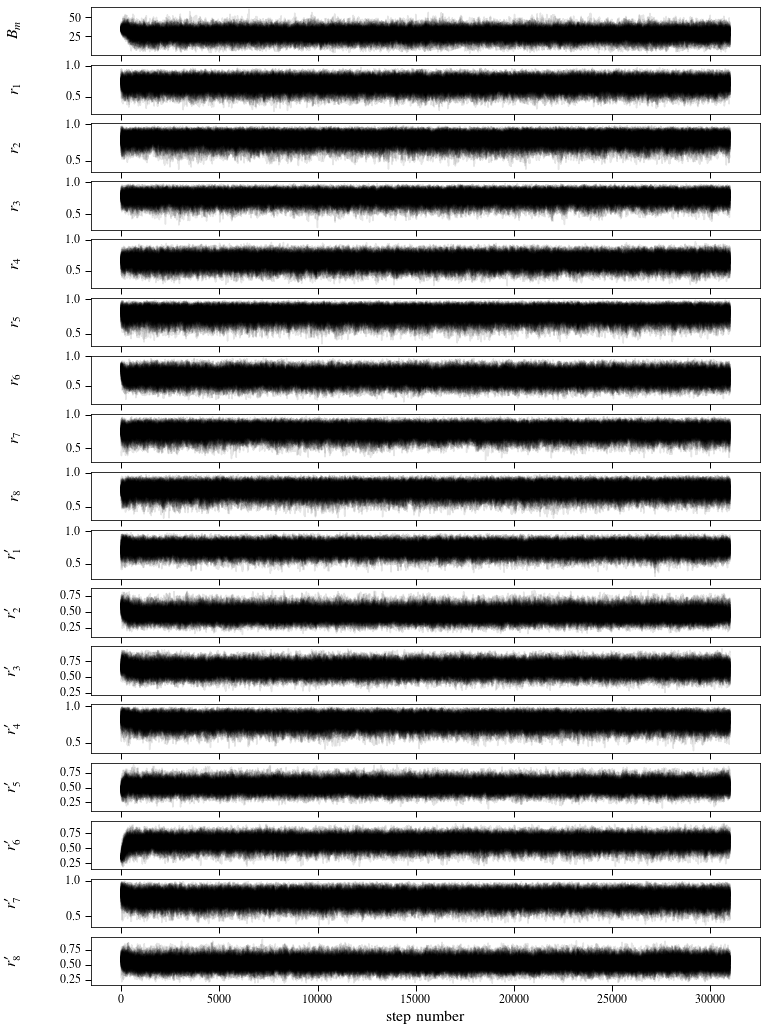

In [11]:
fig, axes = plt.subplots(nrows=ndim, figsize=(12, 18), sharex=True)

samples = sampler.get_chain(discard=0, flat=False, thin=1)

labels = [r'$B_m$'] +\
         list(map(r"$r_{{{0}}}$".format, range(1, len(rjs)+1 ))) +\
         list(map(r"$r'_{{{0}}}$".format, range(1, len(rjps)+1 )))

        
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


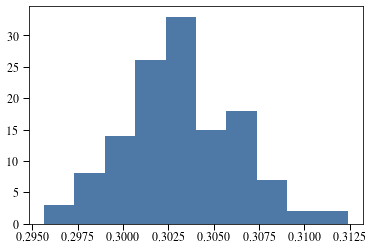

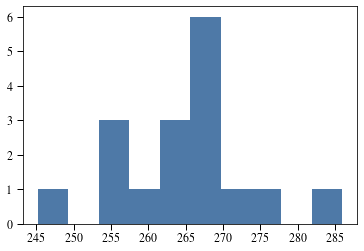

In [12]:
plt.hist(sampler.acceptance_fraction)
plt.figure()
plt.hist(sampler.get_autocorr_time(tol=0))
taus = sampler.get_autocorr_time(tol=0)

In [13]:
samples = sampler.get_chain(discard=2*int(taus.max()), flat=False, thin=5)
inds = (sampler.acceptance_fraction > 0.0)
samples = samples[:,inds].reshape(-1, ndim)

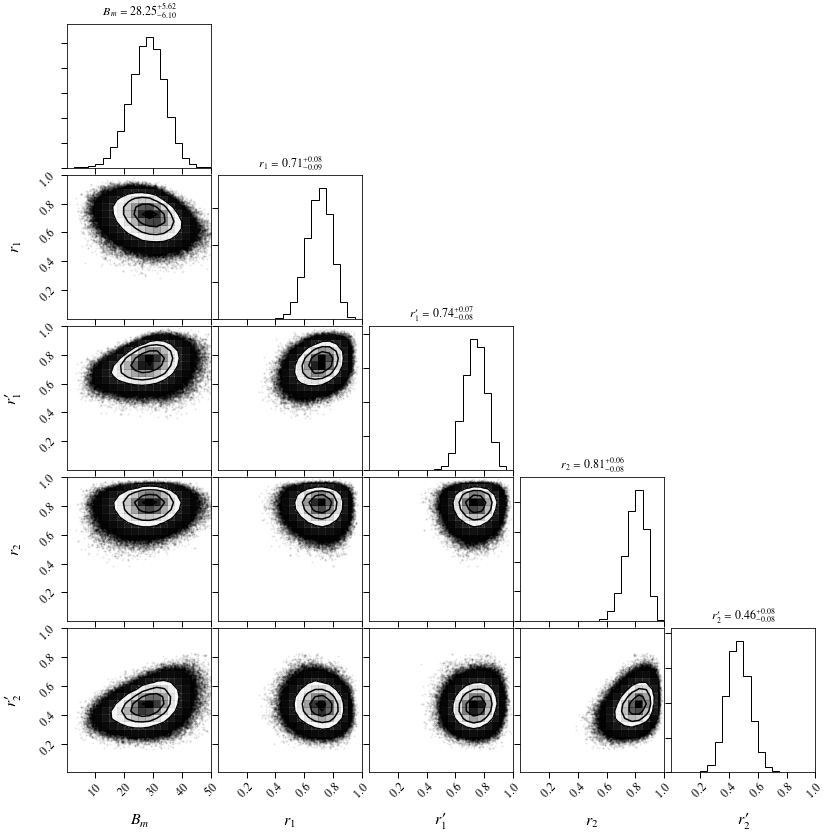

In [14]:
fig = corner(samples[:,[0,1,9,2,10]], labels=[r'$B_m$', r'$r_1$', r"$r_1'$", r'$r_2$', r"$r_2'$",],
            show_titles=True, range=[(0, 50)] + [(0,1)]*4)

burn-in: 571
thin: 122
flat chain shape: (31872, 17)
flat log prob shape: (31872,)


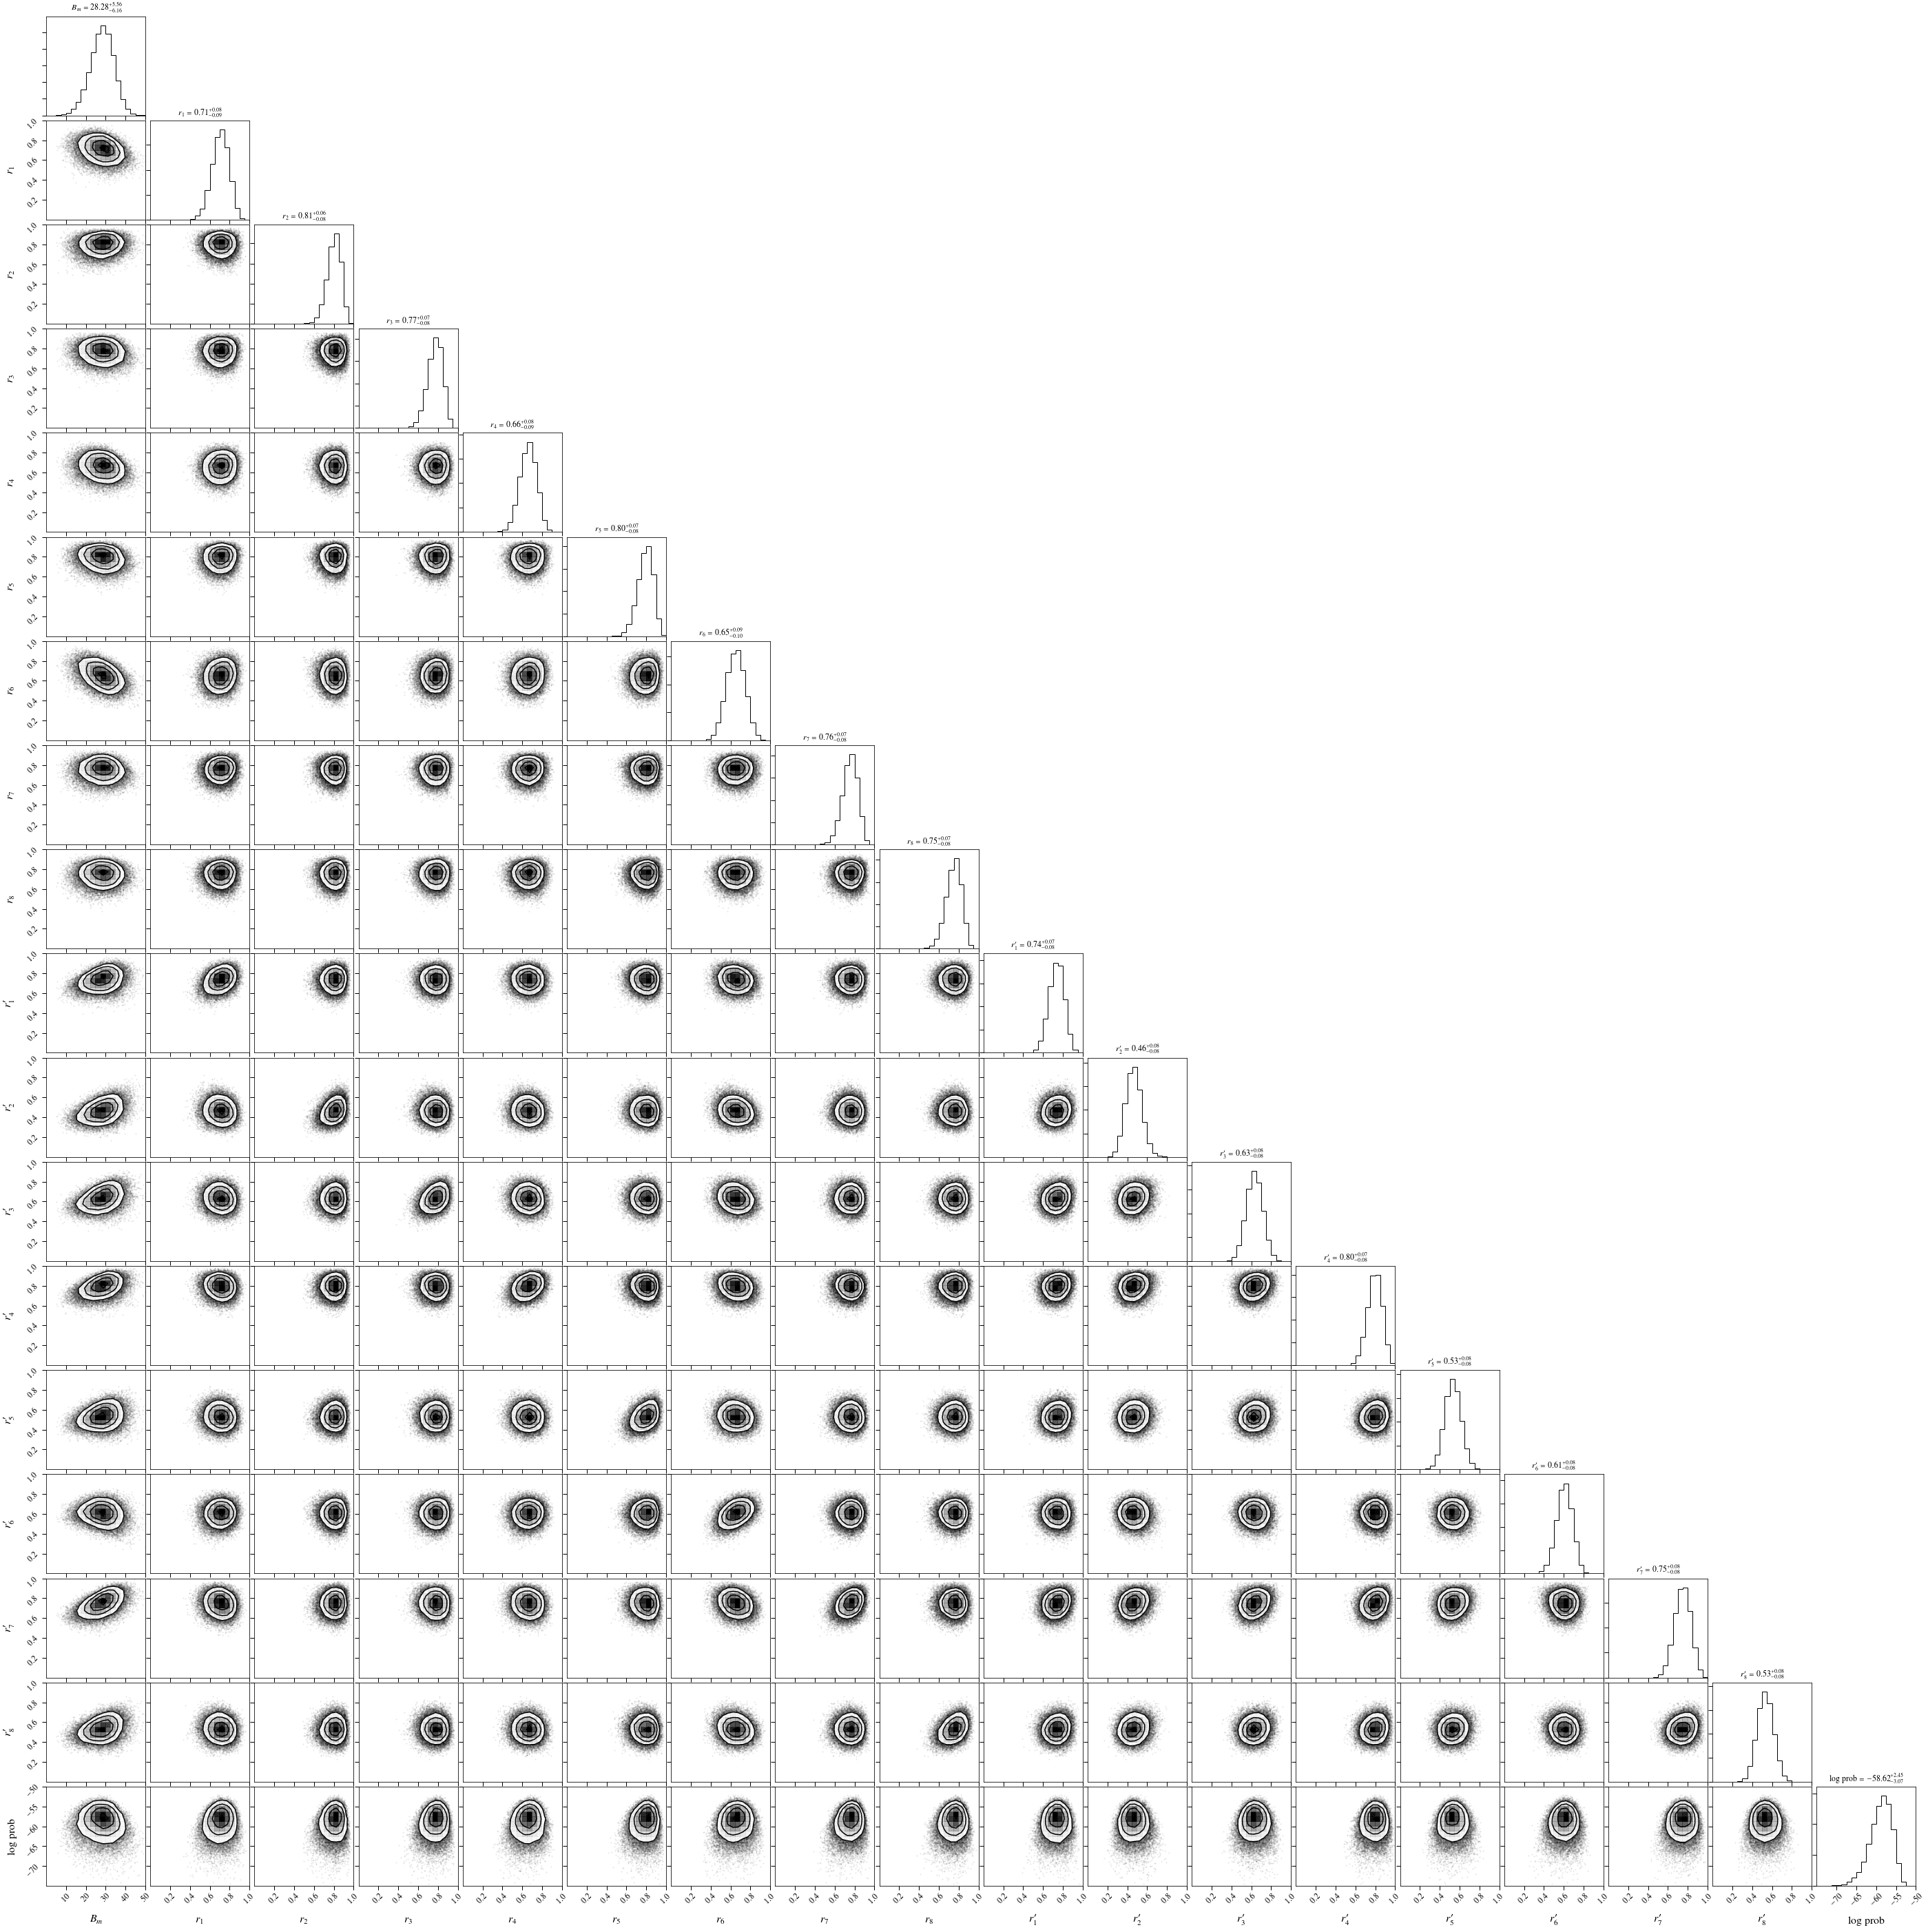

In [15]:
tau = sampler.get_autocorr_time(tol=0)
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))

all_samples = np.concatenate(
    (samples, log_prob_samples[:, None]), axis=1
)

labels = [r'$B_m$'] +\
         list(map(r"$r_{{{0}}}$".format, range(1, len(rjs)+1 ))) +\
         list(map(r"$r'_{{{0}}}$".format, range(1, len(rjps)+1 )))
labels += ["log prob"]

fig = corner(all_samples, labels=labels, show_titles=True, range=[(0, 50)] + [(0,1)]*2*len(rjs) + [(-75, -50)])
plt.savefig('corner_est.pdf', bbox_inches='tight')

In [16]:
%reset -f